# Graph Summarizer

Install the Jaro package through the following command:  
`!pip install jaro-winkler`  
You can reference the installation documentation [here](https://pypi.org/project/jaro-winkler/)

In [1]:
import networkx as nx
import numpy as np
import nltk
import jaro

try:
    from nltk.corpus import stopwords
except:
    import nltk
    nltk.download('stopwords')
finally:
    from nltk.corpus import stopwords

In [25]:
# constants
sw = list(set(stopwords.words('english')))
punct = [
    '!','#','$','%','&','(',')','*',
    '+',',','-','/',':',';','<','=','>','@',
    '[','\\',']','^','_','`','{','|','}','~'
]

## Load Text

I've set up this tutorial in a manner that any body of text can be input to the pipeline. Continue on with this tutorial with the text I've selected or use your own. Below are a set of books you can easily download through the NLTK library and Gutenberg project. All of these books are free to use as they are a part of the public domain.

In [3]:
# free to use books in the public domain which can be fetched by NTLK and project gutenberg
book_choices = [
    'austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt',
    'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt',
    'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt',
    'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt',
    'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt',
    'shakespeare-macbeth.txt', 'whitman-leaves.txt'
]

For the purposes of this tutorial, I will be using Shakespeare's play on Julius Caesar. Do note that this and all other bodies of text written by William Shakespeare is in the [public domain](https://en.wikipedia.org/wiki/Public_domain), as the bodies of text were created prior to the existence of any copyright restrictions [2]. 

In [4]:
try:
    book = nltk.corpus.gutenberg.raw('shakespeare-caesar.txt')
except:
    nltk.download('gutenberg')
finally:
    book = nltk.corpus.gutenberg.raw('shakespeare-caesar.txt')

In [5]:
book[0:1000]

"[The Tragedie of Julius Caesar by William Shakespeare 1599]\n\n\nActus Primus. Scoena Prima.\n\nEnter Flauius, Murellus, and certaine Commoners ouer the Stage.\n\n  Flauius. Hence: home you idle Creatures, get you home:\nIs this a Holiday? What, know you not\n(Being Mechanicall) you ought not walke\nVpon a labouring day, without the signe\nOf your Profession? Speake, what Trade art thou?\n  Car. Why Sir, a Carpenter\n\n   Mur. Where is thy Leather Apron, and thy Rule?\nWhat dost thou with thy best Apparrell on?\nYou sir, what Trade are you?\n  Cobl. Truely Sir, in respect of a fine Workman, I am\nbut as you would say, a Cobler\n\n   Mur. But what Trade art thou? Answer me directly\n\n   Cob. A Trade Sir, that I hope I may vse, with a safe\nConscience, which is indeed Sir, a Mender of bad soules\n\n   Fla. What Trade thou knaue? Thou naughty knaue,\nwhat Trade?\n  Cobl. Nay I beseech you Sir, be not out with me: yet\nif you be out Sir, I can mend you\n\n   Mur. What mean'st thou by tha

## Clean Text

In [6]:
def clean_text(text, sw = sw, punct = punct):
    '''
    This function will clean the input text by lowering, removing certain punctuations, stopwords and 
    new line tags.
    
    params:
        text (String) : The body of text you want to clean
        sw (List) : The list of stopwords you wish to removed from the input text
        punct (List) : The slist of punctuations you wish to remove from the input text
        
    returns:
        This function will return the input text after it's cleaned (the output will be a string)
    '''
    text = text.lower()
    article = text.split(' ')
    # clean stopwords
    article = [x.lstrip().rstrip() for x in article if x not in sw]
    article = [x for x in article if x]
    article = ' '.join(article)
    
    # clean punctuations
    for pun in punct:
        article = article.replace(pun, '')
    
    article = article.replace("[^a-zA-Z]", " ").replace('\r\n', ' ').replace('\n', ' ')
    return article

In [7]:
%time cleaned_book = clean_text(book)

CPU times: user 63.4 ms, sys: 2.07 ms, total: 65.5 ms
Wall time: 64.4 ms


In [8]:
# get sentences
sentences = [x for x in cleaned_book.split('. ') if x not in ['', ' ', '..', '.', '...']]

In [9]:
len(sentences)

1289

## Create Network

In this section we will create an adjacency matrix through the similarity of various sentences. This adjacency matrix will then allow us to create a weighted network (through NetworkX). Please keep in mind the size of your input body of text, since the similarity matrix needs to assign a score for each pair of sentences it will be an extensive and exhausting process for your computer if your body of text is very large (> 2000 sentences).

In the created network, the nodes will be indices associated to the sentences in the book and the edges connecting the sentences will be weighted based on the similarity of a pair of sentences. We can then run the page rank algorithm on that weighted network to identify nodes with a large rank associated to them. 

At very high level, the intuition behind the page rank algorithm is to identify highly popular nodes through the use of [random walks](https://towardsdatascience.com/random-walks-with-restart-explained-77c3fe216bca). It's a very popular network based algorithm Larry Page and was famously used by Google to rank their web pages in their search enginer results [1]. In the context of our example, page rank will tell us highly influential sentences in the network. We can then take the top N most influential sentences, join them together and return them back to the user in the form of a summary of the original body of text. 

In [10]:
def create_similarity_matrix(sentences):
    '''
    The purpose of this function will be to create an N x N similarity matrix.
    N represents the number of sentences and the similarity of a pair of sentences
    will be determined through the Jaro-Winkler Score.
    
    params:
        sentences (List -> String) : This is a list of strings you want to create
                                     the similarity matrix with.
     
    returns:
        This function will return a square numpy matrix
    '''
    
    # identify sentence similarity matrix with Jaro Winkler score
    sentence_length = len(sentences)
    sim_mat = np.zeros((sentence_length, sentence_length))

    for i in range(sentence_length):
        for j in range(sentence_length):
            if i != j:
                similarity = jaro.jaro_winkler_metric(sentences[i], sentences[j])
                sim_mat[i][j] = similarity
    return sim_mat

In [11]:
%time sim_mat = create_similarity_matrix(sentences)

CPU times: user 2min 16s, sys: 335 ms, total: 2min 16s
Wall time: 2min 16s


In [12]:
%%time 
# create network
G = nx.from_numpy_matrix(sim_mat)

CPU times: user 2.35 s, sys: 190 ms, total: 2.54 s
Wall time: 2.69 s


In [13]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1289
Number of edges: 820222
Average degree: 1272.6486


In [14]:
%%time 
# calculate page rank scores
pr_sentence_similarity = nx.pagerank(G)

CPU times: user 10.1 s, sys: 955 ms, total: 11.1 s
Wall time: 11.8 s


The built in page rank function will output a dictionary where the keys are the nodes and the values are the associated page rank score to that node.

In [15]:
# pr_sentence_similarity

In [16]:
ranked_sentences = [
    (sentences[sent], rank) for sent,rank in sorted(pr_sentence_similarity.items(), key=lambda item: item[1], reverse = True)
]

In [18]:
ranked_sentences[0]

('decius well vrgd thinke meet marke antony well beloud caesar should outliue caesar shall finde him a shrewd contriuer',
 0.0008514421863851916)

## Generate Summary

In [22]:
def generate_summary(ranked_sentences, N):
    '''
    This function will generate the summary given a list of ranked sentences and the
    number of sentences the user wants in their summary.
    
    params:
        ranked_sentences (List -> Tuples) : The list of ranked sentences where each
                                            element is a tuple, the first value in the
                                            tuple is the sentence, the second value is
                                            the rank
        N (Integer) : The number of sentences the user wants in the summary
        
    returns:
        This function will return a string associated to the summarized ranked_sentences
        of a book
    '''
    summary = '. '.join([sent[0] for sent in ranked_sentences[0:N]])
    return summary

In [26]:
%%time
N = 10
summary = generate_summary(ranked_sentences, N)

CPU times: user 19 µs, sys: 39 µs, total: 58 µs
Wall time: 63.9 µs


In [27]:
summary

'decius well vrgd thinke meet marke antony well beloud caesar should outliue caesar shall finde him a shrewd contriuer. taper burneth closet sir searching window flint found this paper thus seald vp sure it lye went bed. these as sure do beare fire enough to kindle cowards steele valour the melting spirits women. but compact meane haue vs will prickd number friends or shall on depend you ant. man doth bestride narrow world like colossus petty men walke vnder huge legges peepe about to finde selues dishonourable graues. deepe night crept vpon talke and nature must obey necessitie which niggard little rest there say cassi. noble brutus hath told caesar ambitious if so greeuous fault and greeuously hath caesar answerd it. forget speed antonio to touch calphurnia elders say the barren touched holy chace shake sterrile curse ant. i itching palme you know brutus speakes this or gods speech else last bru. o cassius yoaked lambe that carries anger flint beares fire who much inforced shewes has

## Resources
- [1] https://en.wikipedia.org/wiki/PageRank
- [2] https://en.wikipedia.org/wiki/Public_domain

---

In [3]:
import pandas as pd
import requests
import numpy as np

In [5]:
req = requests.get('http://ufcstats.com/event-details/335ad945324c3a2e')

In [12]:
df = pd.read_html('http://ufcstats.com/event-details/335ad945324c3a2e')[0]

In [13]:
df

,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time
0,win,Francis Ngannou Ciryl Gane,0 0,43 63,4 1,0 3,Heavyweight,U-DEC,5,5:00
1,win,Deiveson Figueiredo Brandon Moreno,3 0,86 105,2 1,0 0,Flyweight,U-DEC,5,5:00
2,win,Michel Pereira Andre Fialho,0 0,107 45,1 0,0 0,Welterweight,U-DEC,3,5:00
3,win,Said Nurmagomedov Cody Stamann,0 0,7 1,0 0,1 0,Bantamweight,SUB Guillotine Choke,1,0:47
4,win,Michael Morales Trevin Giles,1 0,26 8,0 1,0 1,Welterweight,KO/TKO Punches,1,4:06
5,win,Victor Henry Raoni Barcelos,0 0,181 134,0 1,0 0,Bantamweight,U-DEC,3,5:00
6,win,Jack Della Maddalena Pete Rodriguez,1 0,43 25,0 0,0 0,Welterweight,KO/TKO Punch,1,2:59
7,win,Tony Gravely Saimon Oliveira,0 0,46 35,11 0,0 4,Bantamweight,U-DEC,3,5:00
8,win,Matt Frevola Genaro Valdez,4 0,60 10,0 0,0 0,Lightweight,KO/TKO Punches,1,3:15
9,win,Vanessa Demopoulos Silvana Gomez Juarez,0 1,4 10,0 0,2 0,Women's Strawweight,SUB Armbar,1,2:25


In [2]:
levels_fyi_data = requests.get('https://www.levels.fyi/js/salaryData.json').json()
levels_df = pd.DataFrame(levels_fyi_data)
levels_df.shape

(62642, 17)

In [3]:
levels_df = levels_df.drop(['cityid', 'dmaid','rowNumber'], axis=1)
levels_df = levels_df.replace("", np.nan)

In [4]:
levels_df['timestamp'] = pd.to_datetime(levels_df['timestamp'])
levels_df[
    ['yearsofexperience','basesalary','bonus','stockgrantvalue','totalyearlycompensation','yearsatcompany']
] = levels_df[
    ['yearsofexperience','basesalary','bonus','stockgrantvalue','totalyearlycompensation','yearsatcompany']
].apply(pd.to_numeric)

In [11]:
levels_df.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails
0,2017-06-07 11:33:27,Oracle,L3,Product Manager,186,"Redwood City, CA",1,1,NaN,160,17,9,NaN,NaN
1,2017-06-10 17:11:29,eBay,SE 2,Software Engineer,0,"San Francisco, CA",3,4,NaN,0,0,0,NaN,NaN
2,2017-06-11 14:53:57,Amazon,L7,Product Manager,126,"Seattle, WA",10,0,NaN,126,0,0,NaN,NaN
3,2017-06-14 21:22:25,Microsoft,64,Software Engineering Manager,171348,"Redmond, WA",13,13,NaN,92799,55371,23178,NaN,NaN
4,2017-06-16 10:44:01,Amazon,L5,Software Engineer,214175,"Vancouver, BC, Canada",13,1,NaN,156335,0,57840,NaN,NaN


In [12]:
fb = levels_df[levels_df['company'].isin(['Facebook', 'Meta'])]

In [31]:
fb[(fb['title'] == 'Data Scientist') & (fb['basesalary'] != 0)][
    ['yearsofexperience', 'basesalary']
].value_counts().reset_index().rename(columns = {0 : 'count'}).sort_values(by = 'basesalary')

,yearsofexperience,basesalary,count
90,3,63,1
124,1,72,1
46,0,78,1
0,3,78,2
147,0,80,1
...,...,...,...
48,10,280,1
83,9,288,1
63,14,294,1
21,7,303,1


<AxesSubplot:>

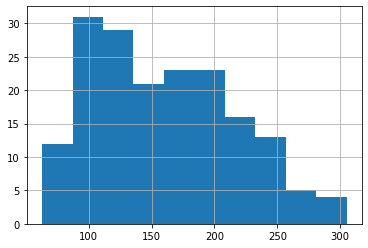

In [21]:
fb[(fb['title'] == 'Data Scientist') & (fb['basesalary'] != 0)].sort_values(by = 'basesalary')['basesalary'].hist()

<AxesSubplot:>

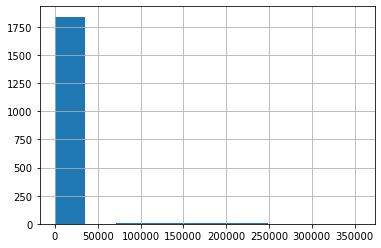

In [22]:
fb[(fb['title'] == 'Software Engineer') & (fb['basesalary'] != 0)].sort_values(by = 'basesalary')['basesalary'].hist()

In [23]:
fb[(fb['title'] == 'Software Engineer') & (fb['basesalary'] != 0)]

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails
23,2017-07-21 15:34:53,Facebook,E6,Software Engineer,485280,"San Francisco, CA",5,7,NaN,175950,267130,42200,NaN,NaN
71,2017-09-04 14:17:07,Facebook,E4,Software Engineer,282,"Menlo Park, CA",1,1,NaN,189,79,14,NaN,NaN
116,2017-10-17 22:57:39,Facebook,E6,Software Engineer,3386013,"Seattle, WA",11,5,NaN,208032,3140803,37178,NaN,schloub kliafy waitz mccreaucs snooks swuew ca...
117,2017-10-19 01:31:35,Facebook,E6,Software Engineer,1661,"Menlo Park, CA",12,1,NaN,305,1320,36,NaN,NaN
121,2017-10-21 13:13:16,Facebook,E3,Software Engineer,149665,"San Francisco, CA",0,0,NaN,78123,47530,24012,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62491,2021-08-15 22:17:26,Facebook,IC4,Software Engineer,262,"Menlo Park, CA",7,4,Web Development (Front-End),185,49,28,NaN,ceosts knaop
62492,2021-08-15 22:20:26,Facebook,E5,Software Engineer,502,"Seattle, WA",7,0,Full Stack,293,183,26,Male,thaab spaagy gnuirn yioupp juasly draasly
62523,2021-08-16 09:20:58,Facebook,E5,Software Engineer,464,"Seattle, WA",7,0,Distributed Systems (Back-End),284,146,34,Male,mcmeucs mcleatch riocy twauv schmiengly yienn
62586,2021-08-16 19:14:27,Facebook,E4,Software Engineer,326,"New York, NY",3,2,Distributed Systems (Back-End),221,92,13,Male,rhoish schroub physaently shieg plaesp wiom sh...


In [34]:
levels_df[levels_df['company'] == 'Databricks'].title.unique()

array(['Solution Architect', 'Software Engineer',
       'Software Engineering Manager', 'Technical Program Manager',
       'Marketing'], dtype=object)